# Import Libraries 

In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import sklearn
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
import time
import pickle
import os

import warnings
warnings.filterwarnings('ignore')

# Load and Select Columns

In [2]:
columns = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
           'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)', 'Activity_Label']
df = pd.read_csv("Scaled_Combined_Active_Gyro_Accel_Cleaned.csv", usecols=columns)

# Preprocess Activity Labels

In [3]:
df['Activity_Label'] = df['Activity_Label'].str.strip().str.lower()

# Label Encoding for Activity Labels

In [4]:
LE = LabelEncoder()
df['Activity_Label'] = LE.fit_transform(df['Activity_Label'])

# Display DataFrame

In [5]:
df

,Accel X (g),Accel Y (g),Accel Z (g),Gyro X (°/s),Gyro Y (°/s),Gyro Z (°/s),Activity_Label
0,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
1,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
2,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
3,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
4,-5.983110,1.247379,8.365341,0.321315,-0.024435,-0.131947,0
...,...,...,...,...,...,...,...
230160,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230161,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230162,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9
230163,8.446744,-4.716577,3.725378,-0.808786,0.274889,-0.142942,9


# Feature and Target Variable Setup

In [6]:
PredictorCol = ['Accel X (g)', 'Accel Y (g)', 'Accel Z (g)',
                'Gyro X (°/s)', 'Gyro Y (°/s)', 'Gyro Z (°/s)']
TargetCol = 'Activity_Label'

X = df[PredictorCol].values
y = df[TargetCol].values

# Train-Test Split

In [7]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.30, 
                                                    random_state=15, 
                                                    stratify = y)

# XGBoost Model Training, Evaluation, and Cross-Validation


===== Stratified Cross-Validation Results =====
Stratified CV Accuracy (mean ± std): 0.9580 ± 0.0029
Training Set Accuracy: 0.9570
Test Set Accuracy: 0.9572

===== Class Names =====
Class Names: ['chair squats' 'light stationary cycling' 'marching in place'
 'seated boxing hooks' 'seated leg extensions'
 'seated medicine ball twists' 'seated side bends' 'side-stepping'
 'standing heel-to-toe walk' 'wall push-ups']

===== Classification Report =====
                             precision    recall  f1-score   support

               chair squats       0.95      0.95      0.95      5553
   light stationary cycling       0.98      0.97      0.98      6509
          marching in place       0.94      0.96      0.95     10967
        seated boxing hooks       0.99      0.95      0.97      7735
      seated leg extensions       0.91      0.95      0.93      5549
seated medicine ball twists       0.98      0.96      0.97      5571
          seated side bends       0.96      0.96      0.96    

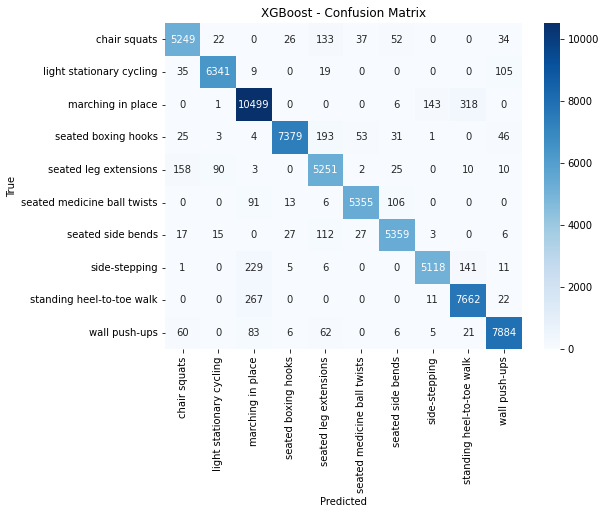

In [8]:
# ====================== XGBoost Model Setup with Best Hyperparameters ======================
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

best_params = {
    'colsample_bytree': 0.6,
    'learning_rate': 0.2,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8
}

# Initialize the XGBClassifier with the best hyperparameters
XGB = XGBClassifier(**best_params)

# =========================== Model Training and Accuracy Calculation ===========================

# Fit the model on the training data
XGB.fit(X_train_sm, y_train_sm)

# Make predictions on the test data
prediction = XGB.predict(X_test_sm)

# Calculate accuracy on the training set
train_accuracy = XGB.score(X_train_sm, y_train_sm)

# Calculate accuracy on the test set
test_accuracy = XGB.score(X_test_sm, y_test_sm)

# ============================= Cross-Validation =============================

# Perform Stratified K-Fold Cross-validation with 10 splits
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Use cross_val_score to get accuracy scores with StratifiedKFold
cv_scores = cross_val_score(XGB, X_train_sm, y_train_sm, cv=stratified_kfold)

# Calculate the mean and standard deviation of the Stratified K-Fold CV results
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()

# =========================== Combined Results ===========================

print("\n===== Stratified Cross-Validation Results =====")
print(f"Stratified CV Accuracy (mean ± std): {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"Training Set Accuracy: {train_accuracy:.4f}")
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# =========================== Classification Report ===========================

# Get class names from the label encoder 
class_names = LE.classes_

# Print the class names
print("\n===== Class Names =====")
print("Class Names:", class_names)

# Print the classification report (precision, recall, f1-score)
print("\n===== Classification Report =====")
print(metrics.classification_report(y_test_sm, prediction, target_names=class_names))

# =========================== Confusion Matrix ===========================

# Generate confusion matrix
conf_matrix = metrics.confusion_matrix(y_test_sm, prediction)

# Convert confusion matrix to a DataFrame for better readability
df_conf_matrix = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Print the confusion matrix
print("\n===== Confusion Matrix =====")
print(df_conf_matrix)

# ======================= Plot Confusion Matrix ========================

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save Trained XGBoost Model

In [9]:
import pickle

with open("XGB_HAR_Combined_Active_Gyro_Accel.pkl", "wb") as file:
    pickle.dump(XGB, file)

print("XGBoost model for HAR with Combined Active Gyroscope and Accelerometer has been successfully saved to 'XGB_HAR_Combined_Active_Gyro_Accel.pkl'")

XGBoost model for HAR with Combined Active Gyroscope and Accelerometer has been successfully saved to 'XGB_HAR_Combined_Active_Gyro_Accel.pkl'
